In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Must import comet before torch, sometimes throws error otherwise.
from img_wang.callbacks import CometCallbackWithGrads
from fastai2.vision.all import show_image, show_images
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, recall_score, \
                            precision_score, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F

from htools import *
from img_wang.data import load_img, get_databunch
from img_wang.models import Encoder, SingleInputBinaryModel, \
    TorchvisionEncoder
from img_wang.torch_utils import gpu_setup, top_mistakes
from incendio.callbacks import MetricHistory, ModelCheckpoint, EarlyStopper
from incendio.core import Trainer
from incendio.metrics import mean_soft_prediction, std_soft_prediction, percent_positive

/opt/conda/envs/fastai/lib/python3.7/site-packages/incendio/callbacks.py:25: UserWarning: Accio not available.
  warnings.warn('Accio not available.')


In [3]:
cd_root()
gpu_setup()

Current directory: /storage/img-wang
Setting seeds for reproducible training.


## Load v0 model (stopped saving weights after v1)

In [132]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/unsup/', 
                                   mode='patchwork', bs=512, pct_pos=.5,
                                   collate_custom=True, num_workers=0)

In [133]:
net = SingleInputBinaryModel(TorchvisionEncoder(), 
                             nn.Linear(2560, 1))

In [134]:
t = Trainer(net, dst, dsv, dlt, dlv, F.binary_cross_entropy_with_logits,
            mode='binary', out_dir='data/models/v0', last_act=torch.sigmoid,
            callbacks=[MetricHistory(None, None),
                       CometCallbackWithGrads('img_wang'),
                       EarlyStopper('loss', 'min', patience=5)],
            metrics=[mean_soft_prediction, std_soft_prediction, percent_positive, 
                     accuracy_score, f1_score, recall_score, precision_score,
                     roc_auc_score])

In [135]:
t.load('trainer.pkl')

2020-09-16 05:47:02,828 [INFO]: Loading weights from data/models/v0/trainer.pkl.


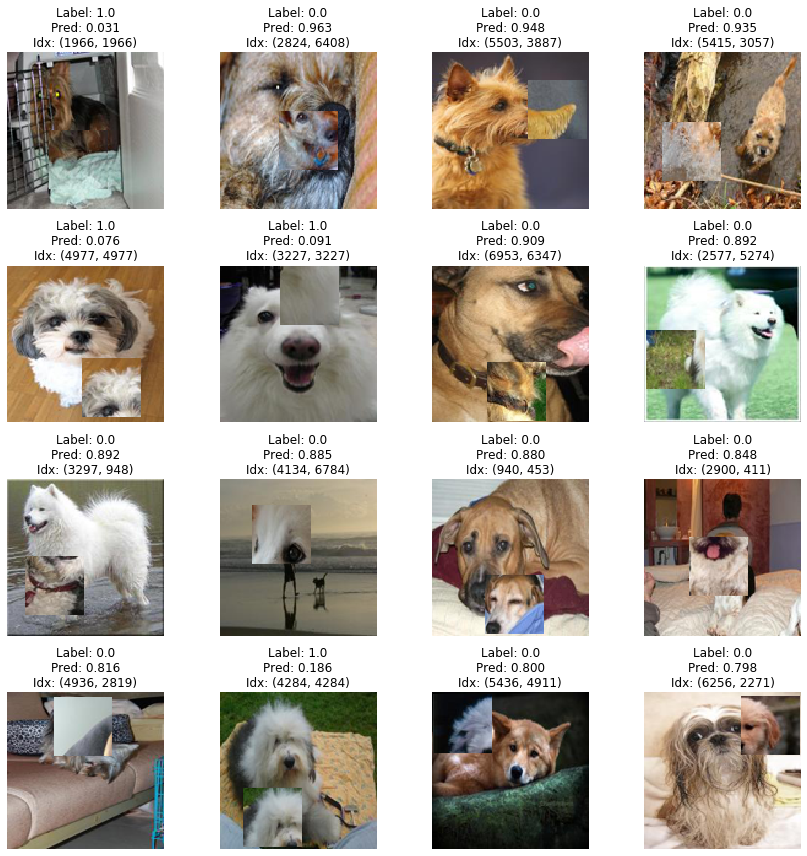

In [136]:
xb, yb = next(iter(dlt))
dft = top_mistakes(t, xb, yb, n=16)

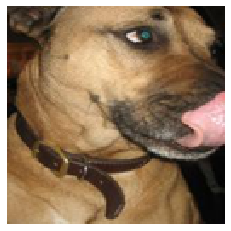

In [140]:
show_image(load_img(dst.paths[6953]))

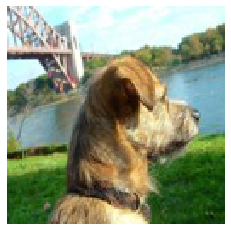

In [141]:
show_image(load_img(dst.paths[6347]))

In [138]:
dft.ends()

,y,y_proba,title
356,1.0,3.116931e-02,"Label: 1.0\nPred: 0.031\nIdx: (1966, 1966)"
42,0.0,9.631147e-01,"Label: 0.0\nPred: 0.963\nIdx: (2824, 6408)"
83,0.0,9.477575e-01,"Label: 0.0\nPred: 0.948\nIdx: (5503, 3887)"
54,0.0,5.668168e-06,"Label: 0.0\nPred: 0.000\nIdx: (4088, 1090)"
380,0.0,4.785597e-06,"Label: 0.0\nPred: 0.000\nIdx: (5354, 625)"
98,0.0,4.276999e-07,"Label: 0.0\nPred: 0.000\nIdx: (946, 1060)"


Some of these samples are labeled as negatives but definitely look like positives. I wonder if there are duplicates in the dataset? If not, that would be a weird bug - can't imagine what would cause that.

There was at least 1 example, though, that looked like the opposite problem (labeled as positive but looks like it came from a different image). That seems like evidence in favor of the "bug" issue over the "duplicates" issue.